### Import dataset


In [2]:
import deeplake
from deeplake import Dataset

ds: Dataset = deeplake.load("hub://activeloop/icdar-2013-text-localize-train")

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.6.25) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/icdar-2013-text-localize-train



/

hub://activeloop/icdar-2013-text-localize-train loaded successfully.



### Data Types


In [3]:
from typing import Dict, Iterator, List, Tuple

import numpy as np

Image = np.ndarray
SubImage = np.ndarray
GradientImg = np.ndarray
Gradients = Tuple[GradientImg, GradientImg]
Dimensions = Tuple[int, int]

Position = Tuple[int, int]
Components = Dict[int, List[Position]]
Gradient = Tuple[float, float]
Ray = Iterator[Tuple[int, int]]

BoundingBox = Tuple[int, int, int, int]
BoundingBoxes = List[BoundingBox]

### Plotting Images


In [4]:
from math import ceil, sqrt

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5.5)


def dims(i):
    c = ceil(sqrt(i))
    r = ceil(i / c)
    return r, c


def plot(images: List[Image], cmap="gray", titles=[]):
    r, c = dims(len(images))
    _, ax = plt.subplots(r, c)

    if len(images) > 1:
        ax = ax.ravel()
        for i, img in enumerate(images):
            ax[i].imshow(img, cmap=cmap)
            ax[i].set_axis_off()
            ax[i].set_title(titles[i])
    else:
        ax.imshow(images[0], cmap=cmap)
        ax.set_axis_off()
        ax.set_title(titles[0])
    plt.tight_layout()
    plt.show()

### Noise Removal


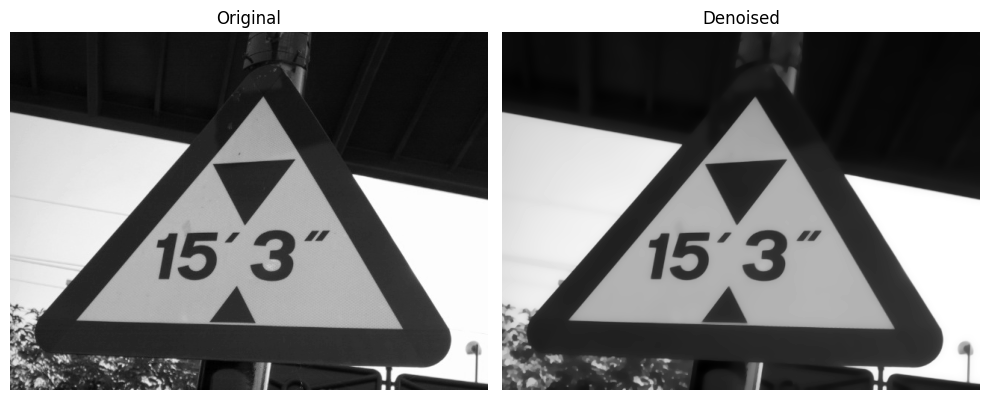

In [168]:
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
from skimage.color import rgb2gray
from random import randint
from skimage.io import imsave, imread

idx = randint(0, 230)
# indices = [3]
# idx = 3
img = rgb2gray(ds.images[idx].numpy())
img_denoised = denoise_tv_chambolle(img)
plot([img, img_denoised], titles=["Original", "Denoised"])

### Invalid Edge Removal


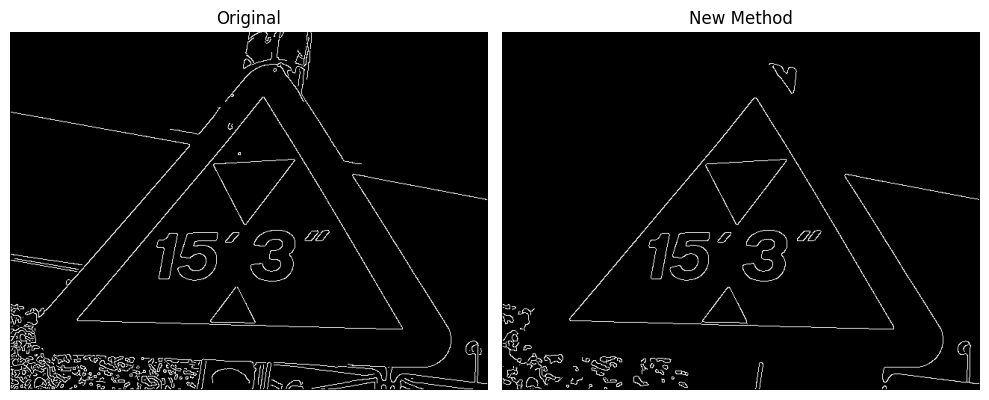

In [169]:
from skimage.feature import canny
import numpy as np
from skimage.filters import threshold_otsu
from skimage.transform import resize, rescale


def store_equivalent_labels(eq_labels: dict, label1: int, label2: int) -> None:
    # Find the root labels for the two labels
    root1 = label1
    while eq_labels.get(root1, None) is not None:
        root1 = eq_labels[root1]
    root2 = label2
    while eq_labels.get(root2, None) is not None:
        root2 = eq_labels[root2]

    # Store the equivalence relationship
    if root1 != root2:
        eq_labels[root2] = root1


def connected_components(edges: Image) -> dict:
    label = 0
    labels = np.zeros(edges.shape, dtype=np.int32)
    eq_labels = {}

    def valid_neighbors(idx):
        # neighbors iterator for 8-connectivity
        def neighbors(idx):
            i, j = idx
            yield i - 1, j
            yield i - 1, j - 1
            yield i - 1, j + 1
            yield i + 1, j
            yield i + 1, j - 1
            yield i + 1, j + 1
            yield i, j - 1
            yield i, j + 1

        # return an array of indices of valid neighbors
        return [labels[p] for p in neighbors(idx) if edges[p] and labels[p]]

    for point in np.argwhere(edges != 0):
        i, j = point

        # get the label values of the valid neighbors of the current point
        neighs = valid_neighbors((i, j))

        # if no neighbors, create a new label
        if not neighs:
            label += 1
            labels[i, j] = label
            continue

        # if one or more neighbor, assign the current point that label
        labels[i, j] = neighs[0]

        # store all labels as equivalent
        for n in neighs[1:]:
            store_equivalent_labels(eq_labels, neighs[0], n)

    # replace all labels with their root labels
    for i, j in np.argwhere(labels != 0):
        root = labels[i, j]
        while eq_labels.get(root, None) is not None:
            root = eq_labels[root]
        labels[i, j] = root

    unique = np.unique(labels)
    components = {l: [] for l in unique if l != 0}

    for index, value in np.ndenumerate(labels):
        if value != 0:
            components[value].append(index)

    return components


def remove_invalid_edges(edges: Image, connected: dict) -> Tuple[Image, Image]:
    edge_map = np.zeros(edges.shape)
    edge_map_display = np.zeros(edges.shape)

    for indices in connected.values():
        # get x and y coordinates of the indices
        xs = [i[0] for i in indices]
        ys = [i[1] for i in indices]

        # x and y dimensions of the bounding box
        xdim, ydim = np.max(xs) - np.min(xs), np.max(ys) - np.min(ys)

        # minimum perimeter bounded polygon
        box_peri = 2 * (xdim + ydim)
        lines_peri = len(indices)

        # ratio of an ellipse in a rectangle
        min_ratio = 0.7

        color = 1
        if box_peri and ((lines_peri / box_peri) < min_ratio):
            color = 0.4

        for i in indices:
            edge_map_display[i] = color
            edge_map[i] = 1 if color > 0.5 else 0

    return edge_map, edge_map_display


def edge_map(img):
    edges = canny(img)
    connected = connected_components(edges)
    return remove_invalid_edges(edges, connected)


og_edge = canny(img)
new_edge, _ = edge_map(img_denoised)
plot([og_edge, new_edge], titles=["Original", "New Method"])

### Stroke Width Transform


#### Derivative Images


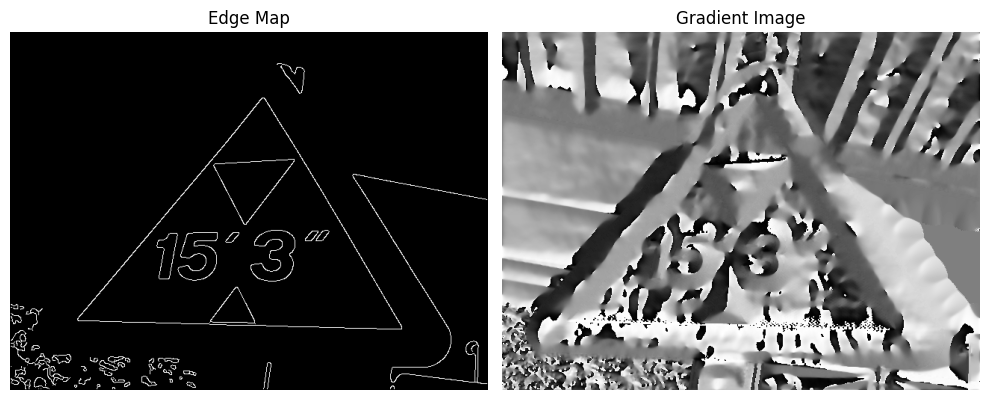

In [170]:
from skimage.filters import scharr_h, scharr_v


def derivatives(img, grad_dir):
    # edge_map and x, y gradients and angles
    gradients = (scharr_h(img), scharr_v(img))
    angles = np.arctan2(gradients[1] * grad_dir, gradients[0] * grad_dir)

    return edge_map(img)[0], gradients, angles


edges, _, angles = derivatives(img_denoised, 1)
plot([edges, angles], titles=["Edge Map", "Gradient Image"])

#### Stroke Width Transform


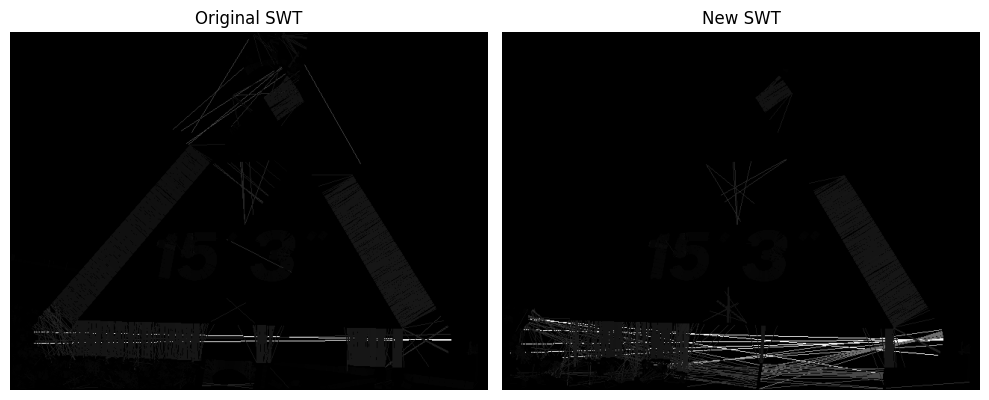

In [174]:
from skimage.draw import line as skline
from math import floor


def project_ray(diag: float, start: Position, angles: Image) -> Ray:
    # Calculate the end point of the line
    end_x = floor(start[0] + diag * np.cos(angles[start]))
    end_y = floor(start[1] + diag * np.sin(angles[start]))
    skline(start[0], start[1], end_x, end_y)

    return zip(*skline(start[0], start[1], end_x, end_y))


def traverse_line(line: Ray, dims: Dimensions, edge_map: Image) -> Position:
    # track if endpoint is found
    end = None

    # skip the current position
    next(line)

    for r, c in line:
        # out of bounds check
        if (r < 0) or (r >= dims[0]) or (c < 0) or (c >= dims[1]):
            break

        # other edge found
        if edge_map[r, c] == 1:
            end = (r, c)
            break

    return end


def angle_between(start: Position, end: Position, gradients: Gradients) -> float:
    v1 = (gradients[0][start], gradients[1][start])
    v2 = (gradients[0][end], gradients[1][end])

    # determine angle by using the formula for the dot product
    dotmag = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.abs(np.arccos(np.clip(dotmag, -1, 1)) - np.pi)
    return angle


def plot_new_line(img: Image, start: Position, end: Position):
    # calculate the distance between the edge point and the endpoint
    dist = np.sqrt((start[0] - end[0]) ** 2 + (start[1] - end[1]) ** 2)
    line = skline(start[0], start[1], end[0], end[1])

    # Update pixels that belong to the new line with the minimum distance
    img[line] = np.minimum(img[line], dist)
    # img[line] = 1

    return line


def set_ray_above_median(ray: Ray, image: Image):
    median_value = np.median(image[ray])

    for r, c in zip(*ray):
        if image[r, c] >= median_value:
            image[r, c] = median_value


def swt(img: Image, edge_map: Image, gradients: Gradients, angles: Image) -> Image:
    # Output image
    projection = np.ones(img.shape) * np.Infinity

    # collection of rays
    rays = []

    # image dimensions
    dims = (img.shape[0], img.shape[1])

    # diagonal of image for initial line projection length
    diaglen = np.sqrt(dims[0] ** 2 + dims[1] ** 2)

    # loop the edges in the edge map
    for edge_x, edge_y in np.argwhere(edge_map == 1):
        start = edge_x, edge_y

        # project a line from the edge point in the direction of the gradient
        ray = project_ray(diaglen, start, angles)

        # track if endpoint is found
        end = traverse_line(ray, dims, edge_map)

        if end is None:
            continue

        # lines that are not roughly opposite are discarded
        if angle_between(start, end, gradients) > np.pi / 4:
            continue

        # plot the new line
        new_ray = plot_new_line(projection, start, end)
        rays.append(new_ray)

    # set all the upper bounds back to 0
    projection[projection == np.Infinity] = 0

    for ray in rays:
        set_ray_above_median(ray, projection)

    return projection


_, gradients, angles = derivatives(img, -1)
og_swt = swt(img, og_edge, gradients, angles)
edges, gradients, angles = derivatives(img_denoised, -1)
new_swt = swt(img_denoised, edges, gradients, angles)

plot([og_swt, new_swt], titles=["Original SWT", "New SWT"])

#### Removing Outliers


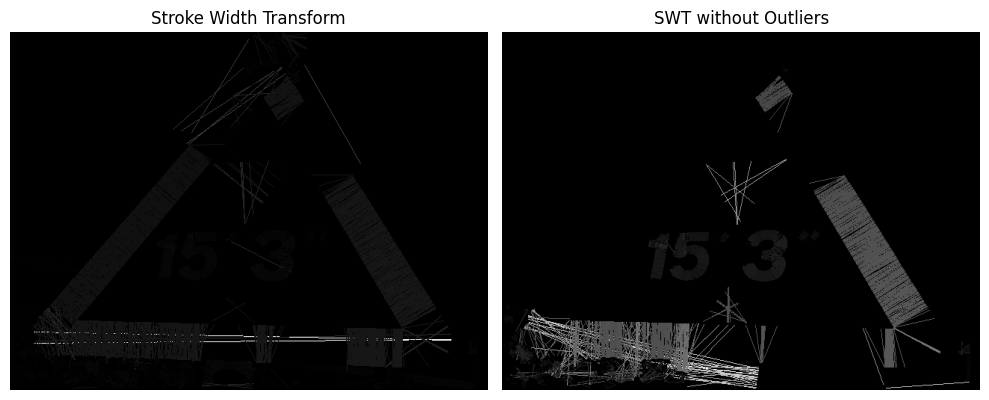

In [175]:
from skimage import draw, filters, img_as_float


def remove_outliers_swt(swt: Image):
    filtered = np.copy(swt)
    vals = swt[swt > 0]
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1
    lower_bound = q1 - (2 * iqr)
    upper_bound = q3 + (2 * iqr)

    filtered[swt > upper_bound] = 0
    filtered[swt < lower_bound] = 0

    return filtered


og_swt_filtered = og_swt
new_swt_filtered = remove_outliers_swt(new_swt)
plot(
    [og_swt_filtered, new_swt_filtered],
    titles=["Stroke Width Transform", "SWT without Outliers"],
)

### Connected Components


C:\Users\johan\AppData\Local\Temp\ipykernel_8352\2311755613.py:14: RuntimeWarning: divide by zero encountered in long_scalars
  if len(indices) / area < lim_ratio:


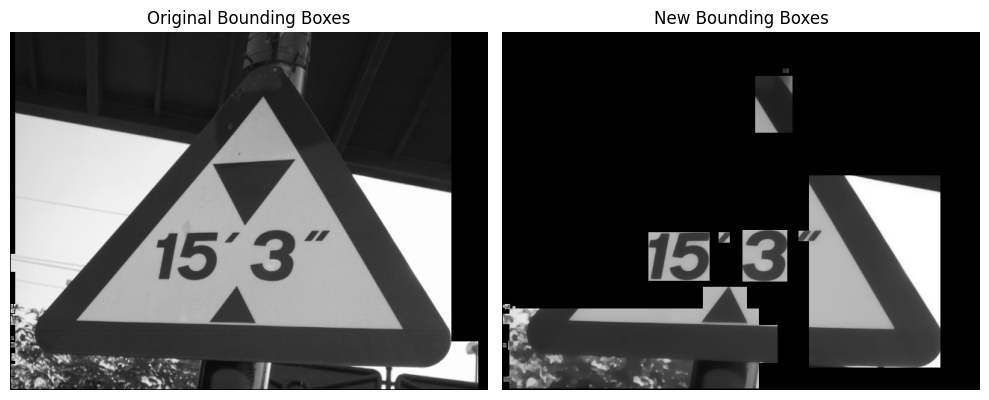

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [176]:
def bounding_boxes(swt: Image, connected: Components) -> BoundingBoxes:
    boxes = []
    for _, indices in connected.items():
        xs = [i[0] for i in indices]
        ys = [i[1] for i in indices]
        xmin, xmax = np.min(xs), np.max(xs)
        ymin, ymax = np.min(ys), np.max(ys)
        xdim, ydim = xmax - xmin, ymax - ymin

        lim_ratio = 0.1
        area = xdim * ydim

        # strokes make up less than 10% of the area
        if len(indices) / area < lim_ratio:
            continue

        # aspect ratio too large
        # if xdim / ydim > 8 or ydim / xdim > 8:
        #     continue
        # swt_values = [swt[i] for i in indices]
        # median = np.median(swt_values)
        # diameter = np.sqrt(xdim**2 + ydim**2)

        # perimeter / median too large
        # if diameter / median > 10:
        #     continue
        boxes.append((xmin, ymin, xmax, ymax))
        # using the xmin, ymin, xmax, ymax give me the pixels in the box

    return boxes


def draw_boxes(img: Image, boxes: BoundingBoxes) -> Image:
    img_cpy = np.zeros(img.shape)
    # color = np.min(img_cpy)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rr, cc = draw.rectangle((xmin, ymin), (xmax, ymax))
        img_cpy[rr, cc] = img[rr, cc]
    return img_cpy


og_connected_dict = connected_components(og_swt_filtered)
og_boxes = bounding_boxes(og_swt_filtered, og_connected_dict)
og_boxed_img = draw_boxes(img, og_boxes)

new_connected_dict = connected_components(new_swt_filtered)
new_boxes = bounding_boxes(new_swt_filtered, new_connected_dict)
new_boxed_img = draw_boxes(img_denoised, new_boxes)

plot(
    [og_boxed_img, new_boxed_img],
    titles=["Original Bounding Boxes", "New Bounding Boxes"],
)
imsave("old5.png", og_boxed_img)
imsave("new5.png", new_boxed_img)
imsave("o5.png", img)